In [24]:
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from utils import z_normalize_column, synchronize_trials, remove_artifacts_from_column, bandpass, segment_column, decompose_segment, extract_features, top_bot_25, time_diff

eeg_data_1 = pd.read_csv('data/muselsl-sample-10min-7.csv')
gradcpt_data_1 = pd.read_csv('data/gradcpt-sample-10min-7.csv')
eeg_data_2 = pd.read_csv('data/muselsl-sample-10min-8.csv')
gradcpt_data_2 = pd.read_csv('data/gradcpt-sample-10min-8.csv')
eeg_data_3 = pd.read_csv('data/muselsl-sample-10min-9.csv')
gradcpt_data_3 = pd.read_csv('data/gradcpt-sample-10min-9.csv')

# Channels
channels = ['AF7', 'AF8', 'TP9', 'TP10'] 

# Add a column to indicate the trial number
eeg_data_1['trial'] = 1
gradcpt_data_1['trial'] = 1
eeg_data_2['trial'] = 2
gradcpt_data_2['trial'] = 2
eeg_data_3['trial'] = 3
gradcpt_data_3['trial'] = 3

In [25]:
# Sync trial start and end times
gradcpt_data_3 = gradcpt_data_3[300:].reset_index(drop=True) # drop first 2 trials because they can be unstable

eeg_data_1, gradcpt_data_1 = synchronize_trials(eeg_data_1, gradcpt_data_1)
eeg_data_2, gradcpt_data_2 = synchronize_trials(eeg_data_2, gradcpt_data_2)
eeg_data_3, gradcpt_data_3 = synchronize_trials(eeg_data_3, gradcpt_data_3)

# Concatenate the trials
eeg_data = pd.concat([eeg_data_1, eeg_data_2, eeg_data_3], ignore_index=True)
gradcpt_data = pd.concat([gradcpt_data_1, gradcpt_data_2, gradcpt_data_3], ignore_index=True)

Gradcpt data had to be truncated
Gradcpt data had to be truncated


### z-normalization

In [26]:
for channel in channels:
    eeg_data[f'{channel}_normal'] = z_normalize_column(eeg_data[channel])

### Remove artifacts

In [27]:
for channel in channels:
    eeg_data[f'{channel}_artif_removed'] = remove_artifacts_from_column(eeg_data[f'{channel}_normal'])

### Bandpass

In [28]:
for channel in channels:
    eeg_data[f'{channel}_bandpassed'] = bandpass(eeg_data[f'{channel}_artif_removed'])

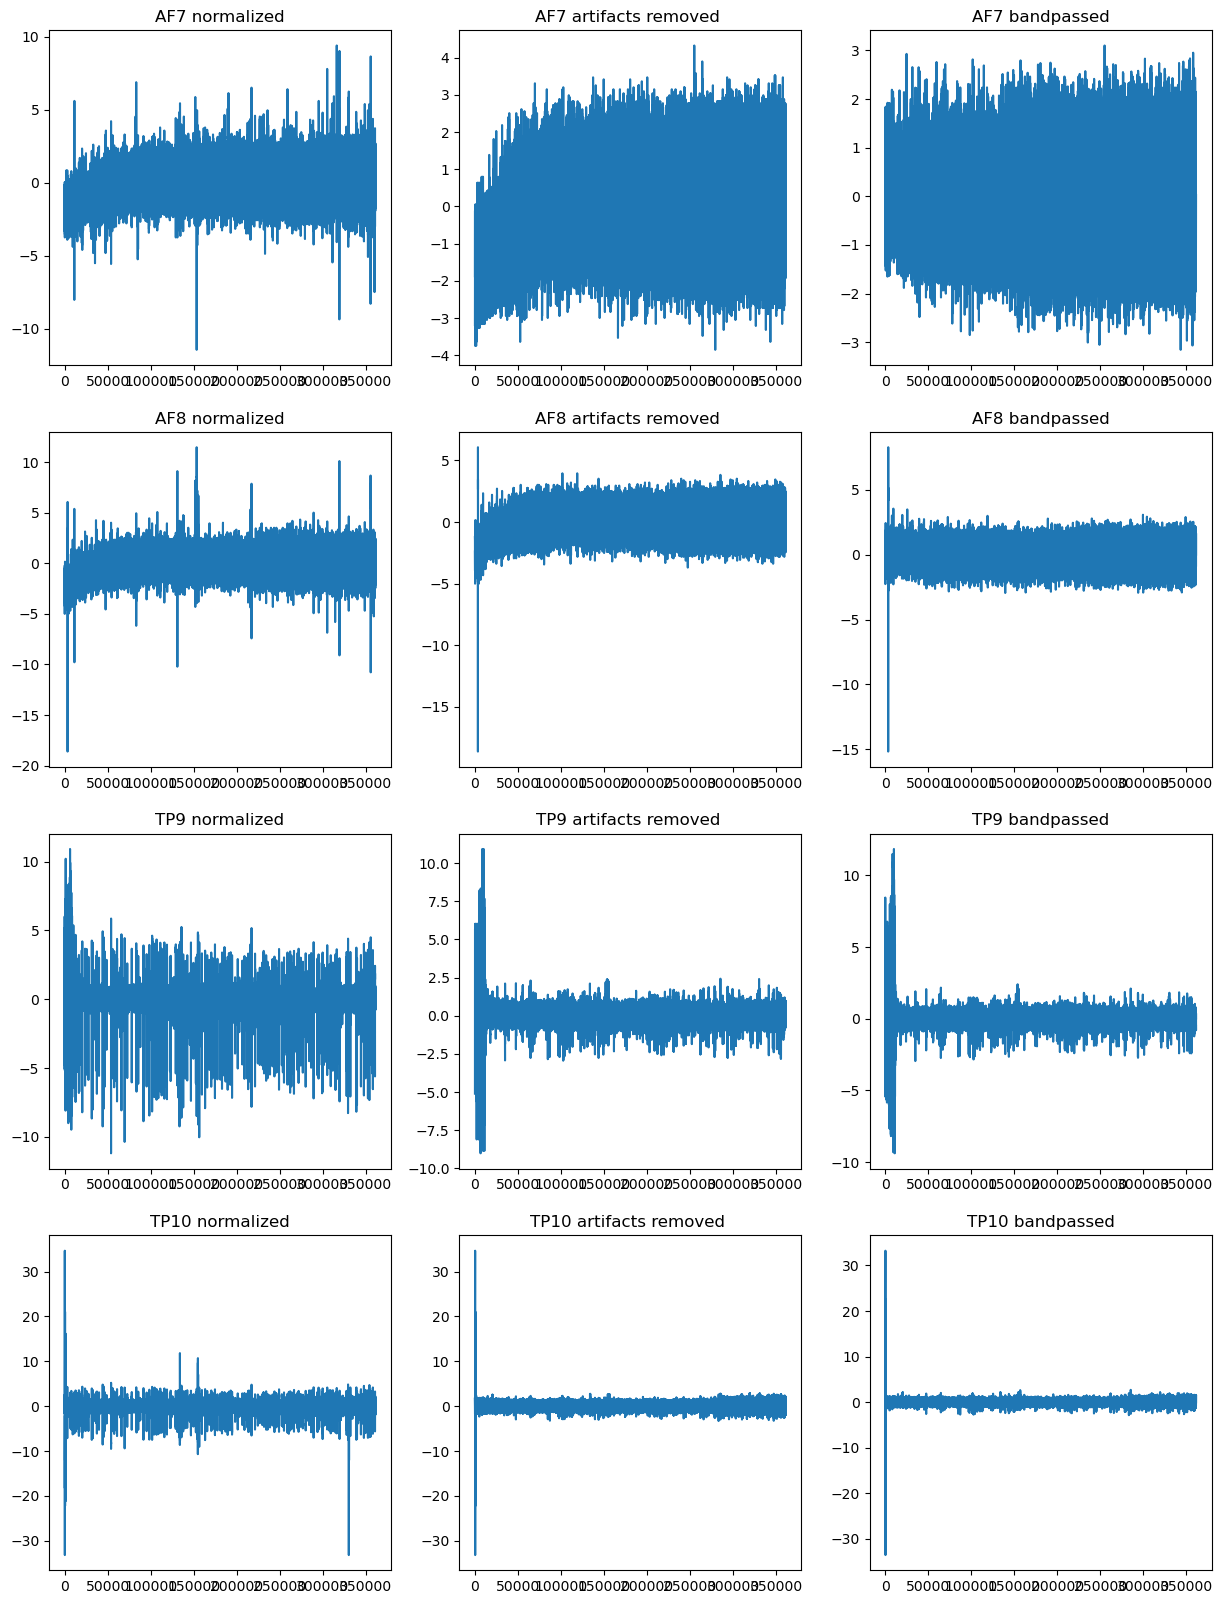

In [29]:
plt.figure(figsize=(15,20))

for i, channel in enumerate(channels):
    plt.subplot(4, 3, i*3+1)
    plt.plot(eeg_data[f'{channel}_normal'], label=f'{channel} normalized')
    plt.title(f'{channel} normalized')

    plt.subplot(4, 3, i*3+2)
    plt.plot(eeg_data[f'{channel}_artif_removed'], label=f'{channel} artifacts removed')
    plt.title(f'{channel} artifacts removed ')

    plt.subplot(4, 3, i*3+3)
    plt.plot(eeg_data[f'{channel}_bandpassed'], label=f'{channel} bandpassed')
    plt.title(f'{channel} bandpassed')

### Separate trials

In [30]:
# Separate preprocessed data back into individual trials
eeg_data_t1 = eeg_data[eeg_data['trial'] == 1].drop(columns=['trial'])
gradcpt_data_t1 = gradcpt_data[gradcpt_data['trial'] == 1].drop(columns=['trial'])

eeg_data_t2 = eeg_data[eeg_data['trial'] == 2].drop(columns=['trial']).reset_index(drop=True)
gradcpt_data_t2 = gradcpt_data[gradcpt_data['trial'] == 2].drop(columns=['trial']).reset_index(drop=True)

eeg_data_t3 = eeg_data[eeg_data['trial'] == 3].drop(columns=['trial']).reset_index(drop=True)
gradcpt_data_t3 = gradcpt_data[gradcpt_data['trial'] == 3].drop(columns=['trial']).reset_index(drop=True)

### Time differences in trials

Text(0.5, 1.0, 'EEG')

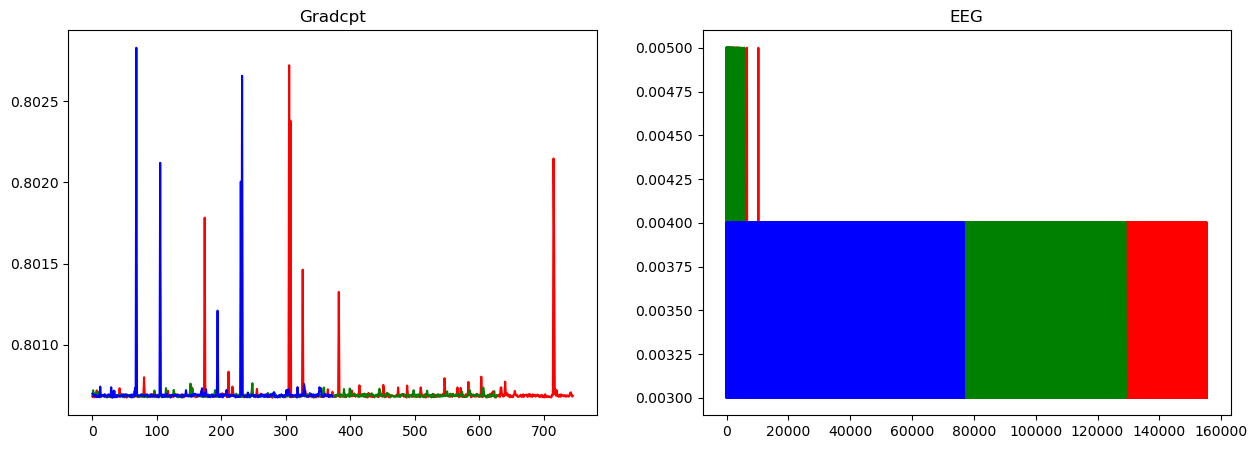

In [31]:
def trial_length(arr):
    diffs = []
    for i in range(1, len(arr)):
        diffs.append(arr[i] - arr[i-1])
    return diffs


plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(trial_length(gradcpt_data_t1['start_timestamp']), color='r')
plt.plot(trial_length(gradcpt_data_t2['start_timestamp']), color='g')
plt.plot(trial_length(gradcpt_data_t3['start_timestamp']), color='b')
plt.title('Gradcpt')

plt.subplot(1, 2, 2)
plt.plot(trial_length(eeg_data_t1['timestamps']), color='r')
plt.plot(trial_length(eeg_data_t2['timestamps']), color='g')
plt.plot(trial_length(eeg_data_t3['timestamps']), color='b')
plt.title('EEG')

In [32]:
def time_diff(eeg_df, gradcpt_df):
    segment_samples = 205

    num_segments = len(gradcpt_df['in_the_zone'])
    diffs = []
    for i in range(num_segments):
        eeg_i = i*segment_samples
        diff = (eeg_df['timestamps'][eeg_i] - gradcpt_df['start_timestamp'][i]) * 1000 # ms
        diffs.append(diff)
    
    return diffs

diffs_t1 = time_diff(eeg_data_t1, gradcpt_data_t1)
diffs_t2 = time_diff(eeg_data_t2, gradcpt_data_t2)
diffs_t3 = time_diff(eeg_data_t3, gradcpt_data_t3)

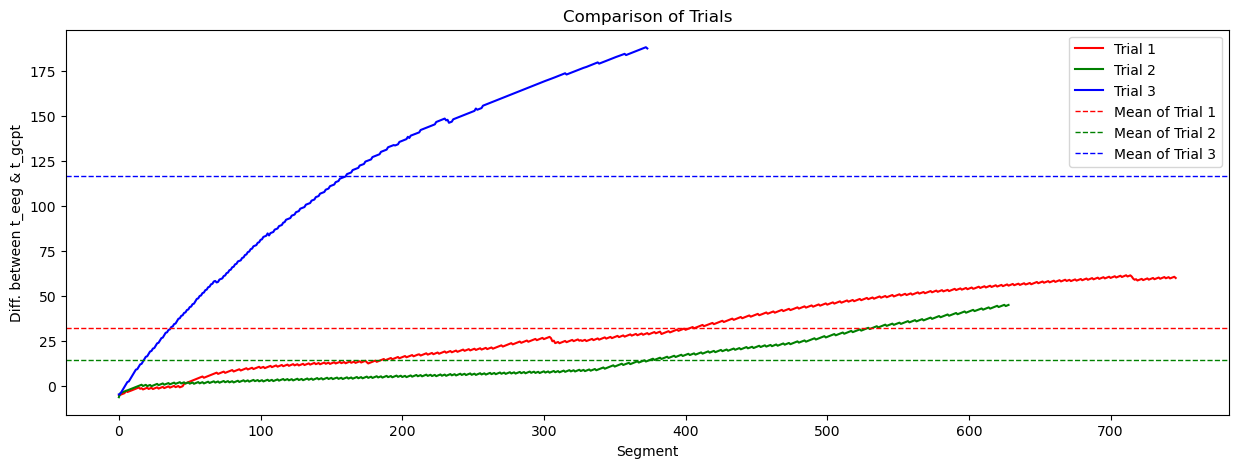

Avg. diff in segment in trial 1: 0.04264090666192903
Avg. diff in segment in trial 2: 0.023151760680839642
Avg. diff in segment in trial 3: 0.31227851098769216


In [33]:
plt.figure(figsize=(15, 5))

plt.plot(diffs_t1, label='Trial 1',  color='r')
plt.plot(diffs_t2, label='Trial 2',  color='g')
plt.plot(diffs_t3, label='Trial 3',  color='b')

# Calculate means
mean_t1 = np.mean(diffs_t1)
mean_t2 = np.mean(diffs_t2)
mean_t3 = np.mean(diffs_t3)

# Plot means
plt.axhline(y=mean_t1, color='r', linestyle='--', label='Mean of Trial 1', linewidth=1)
plt.axhline(y=mean_t2, color='g', linestyle='--', label='Mean of Trial 2', linewidth=1)
plt.axhline(y=mean_t3, color='b', linestyle='--', label='Mean of Trial 3', linewidth=1)

plt.title('Comparison of Trials')
plt.xlabel('Segment')
plt.ylabel('Diff. between t_eeg & t_gcpt')
plt.legend()

plt.show()

print(f'Avg. diff in segment in trial 1: {mean_t1/len(diffs_t1)}')
print(f'Avg. diff in segment in trial 2: {mean_t2/len(diffs_t2)}')
print(f'Avg. diff in segment in trial 3: {mean_t3/len(diffs_t3)}')

### Extract features

In [34]:
# Initialize empty DataFrames for each trial
features_t1 = pd.DataFrame()
features_t2 = pd.DataFrame()
features_t3 = pd.DataFrame()

for trial in [1, 2, 3]:
    # Select the current trial data
    if trial == 1:
        cur_eeg_df = eeg_data_t1
        cur_gcpt_df = gradcpt_data_t1
    elif trial == 2:
        cur_eeg_df = eeg_data_t2
        cur_gcpt_df = gradcpt_data_t2
    else:
        cur_eeg_df = eeg_data_t3
        cur_gcpt_df = gradcpt_data_t3
    
    # Process each channel
    for i, channel in enumerate(channels):
        # Segment the current EEG data
        segments = segment_column(cur_eeg_df[f'{channel}_bandpassed'], cur_gcpt_df)
        # Decompose each segment
        segment_bands = [decompose_segment(segment) for segment in segments]
        # Extract features from the decomposed segments
        features = extract_features(channel, segment_bands)
        
        # Append the features to the respective DataFrame
        if trial == 1:
            features_t1 = pd.concat([features_t1, features], axis=1)
        elif trial == 2:
            features_t2 = pd.concat([features_t2, features], axis=1)
        else:
            features_t3 = pd.concat([features_t3, features], axis=1)
        
        clear_output(wait=True)
        print(f'{(trial-1)*len(channels)+i+1}/{3*len(channels)} Done')

features_t1['in_the_zone'] = gradcpt_data_t1['in_the_zone']
features_t2['in_the_zone'] = gradcpt_data_t2['in_the_zone']
features_t3['in_the_zone'] = gradcpt_data_t3['in_the_zone']

/home/henri/miniconda3/envs/training-env/lib/python3.11/site-packages/scipy/signal/_spectral_py.py:589: UserWarning: nperseg = 256 is greater than input length  = 205, using nperseg = 205
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,


KeyboardInterrupt: 

In [ ]:
combined_features_df = pd.concat([features_t2, features_t3], ignore_index=True)

## Detach rocket

### Train and eval

In [ ]:
from detach_rocket.detach_classes import DetachMatrix
from sklearn.model_selection import train_test_split

X = combined_features_df.iloc[:, :-1]
y = combined_features_df.iloc[:, -1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

detach_matrix = DetachMatrix()
detach_matrix.fit(X_train, y_train)

# Evaluate Performance on Test Set
detach_test_score, full_test_score= detach_matrix.score(X_test, y_test)
print('Test Accuraccy Full Model: {:.2f}%'.format(100*full_test_score))
print('Test Accuraccy Detach Model: {:.2f}%'.format(100*detach_test_score))

### Plot SFD Curve and Optimal Model selection

In [ ]:
percentage_vector = detach_matrix._percentage_vector
acc_curve = detach_matrix._sfd_curve

c = detach_matrix.trade_off

x=(percentage_vector) * 100
y=(acc_curve/acc_curve[0]-1) * 100

point_x = x[detach_matrix._max_index]
#point_y = y[DetachMatrixModel._max_index]

plt.figure(figsize=(8,3.5))
plt.axvline(x = point_x, color = 'r',label=f'Optimal Model (c={c})')
plt.plot(x, y, label='SFD curve', linewidth=2.5, color='C7', alpha=1)
#plt.scatter(point_x, point_y, s=50, marker='o', label=f'Optimal point (c={c})')

plt.grid(True, linestyle='-', alpha=0.5)
plt.xlim(102,-2)
plt.xlabel('% of Retained Features')
plt.ylabel('Relative Validation Set Accuracy (%)')
plt.legend()
plt.show()

print('Optimal Model Size: {:.2f}% of full model'.format(point_x))

### Keep the optimal features

In [ ]:
# Check if '_feature_mask' is available and use it to filter features
if hasattr(detach_matrix, '_feature_mask'):
    feature_mask = detach_matrix._feature_mask
    
    # Use the mask to select features from the training and test sets
    X_train_selected = X_train.loc[:, feature_mask]
    X_test_selected = X_test.loc[:, feature_mask]
else:
    print("Feature mask not found in DetachMatrix object.")

# Add the labels back to the selected feature sets
X_train_selected_with_labels = X_train_selected.assign(Label=y_train)
X_test_selected_with_labels = X_test_selected.assign(Label=y_test)

# Concatenate the training and test sets back into a single DataFrame
selected_features_df = pd.concat([X_train_selected_with_labels, X_test_selected_with_labels], ignore_index=True)

### Train the model

In [ ]:
def train(runs, num_features, df):
    results = []
    
    for _ in range(runs):
        from scipy.stats import ttest_ind
        from sklearn.model_selection import StratifiedKFold, GridSearchCV
        from sklearn.metrics import balanced_accuracy_score
        from sklearn.svm import SVC
        
        features = df.iloc[:, :-1].values
        labels = df.iloc[:, -1].values
        
        def select_top_features(X, y, num_features=num_features):
            # Perform a t-test across features
            t_stats, p_values = ttest_ind(X[y == 0], X[y == 1], axis=0)
            # Select indices of top features based on smallest p-values
            top_features_indices = np.argsort(np.abs(t_stats))[-num_features:]
            return top_features_indices
        
        outer_cv = StratifiedKFold(n_splits=10, shuffle=True)
        
        balanced_acc_scores = []
        
        for train_index, test_index in outer_cv.split(features, labels):
            X_train, X_test = features[train_index], features[test_index]
            y_train, y_test = labels[train_index], labels[test_index]
        
            # Feature selection for the outer fold
            top_features_indices = select_top_features(X_train, y_train)
            X_train_selected = X_train[:, top_features_indices]
            X_test_selected = X_test[:, top_features_indices]
        
            # Inner CV for hyperparameter truning
            inner_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
            param_grid = {'C': [0.1, 1, 10], 'gamma': ['scale', 'auto'], 'kernel': ['rbf']}
            grid_search = GridSearchCV(SVC(), param_grid, cv=inner_cv, scoring='balanced_accuracy')
            grid_search.fit(X_train_selected, y_train)
        
            best_model = grid_search.best_estimator_
            
        
            balanced_acc = balanced_accuracy_score(y_test, best_model.predict(X_test_selected))
            balanced_acc_scores.append(balanced_acc)
        
        final_performance = np.mean(balanced_acc_scores)
        results.append(round(final_performance, 3))
    print(f'Runs: {results}')
    print(f'Avg: {round((sum(results) / len(results)) * 100, 3)}%')

In [ ]:
for feats in [1, 5, 10, 15, 20, 25, 30, 45]:
    print(f'---{feats} features---')
    print('trial 1')
    train(runs=5, num_features=feats, df=features_t1)
    print('trial 2')
    train(runs=5, num_features=feats, df=features_t2)
    print('trial 3')
    train(runs=5, num_features=feats, df=features_t3)